# Nipype Full Framework Demo

## Microservices Model

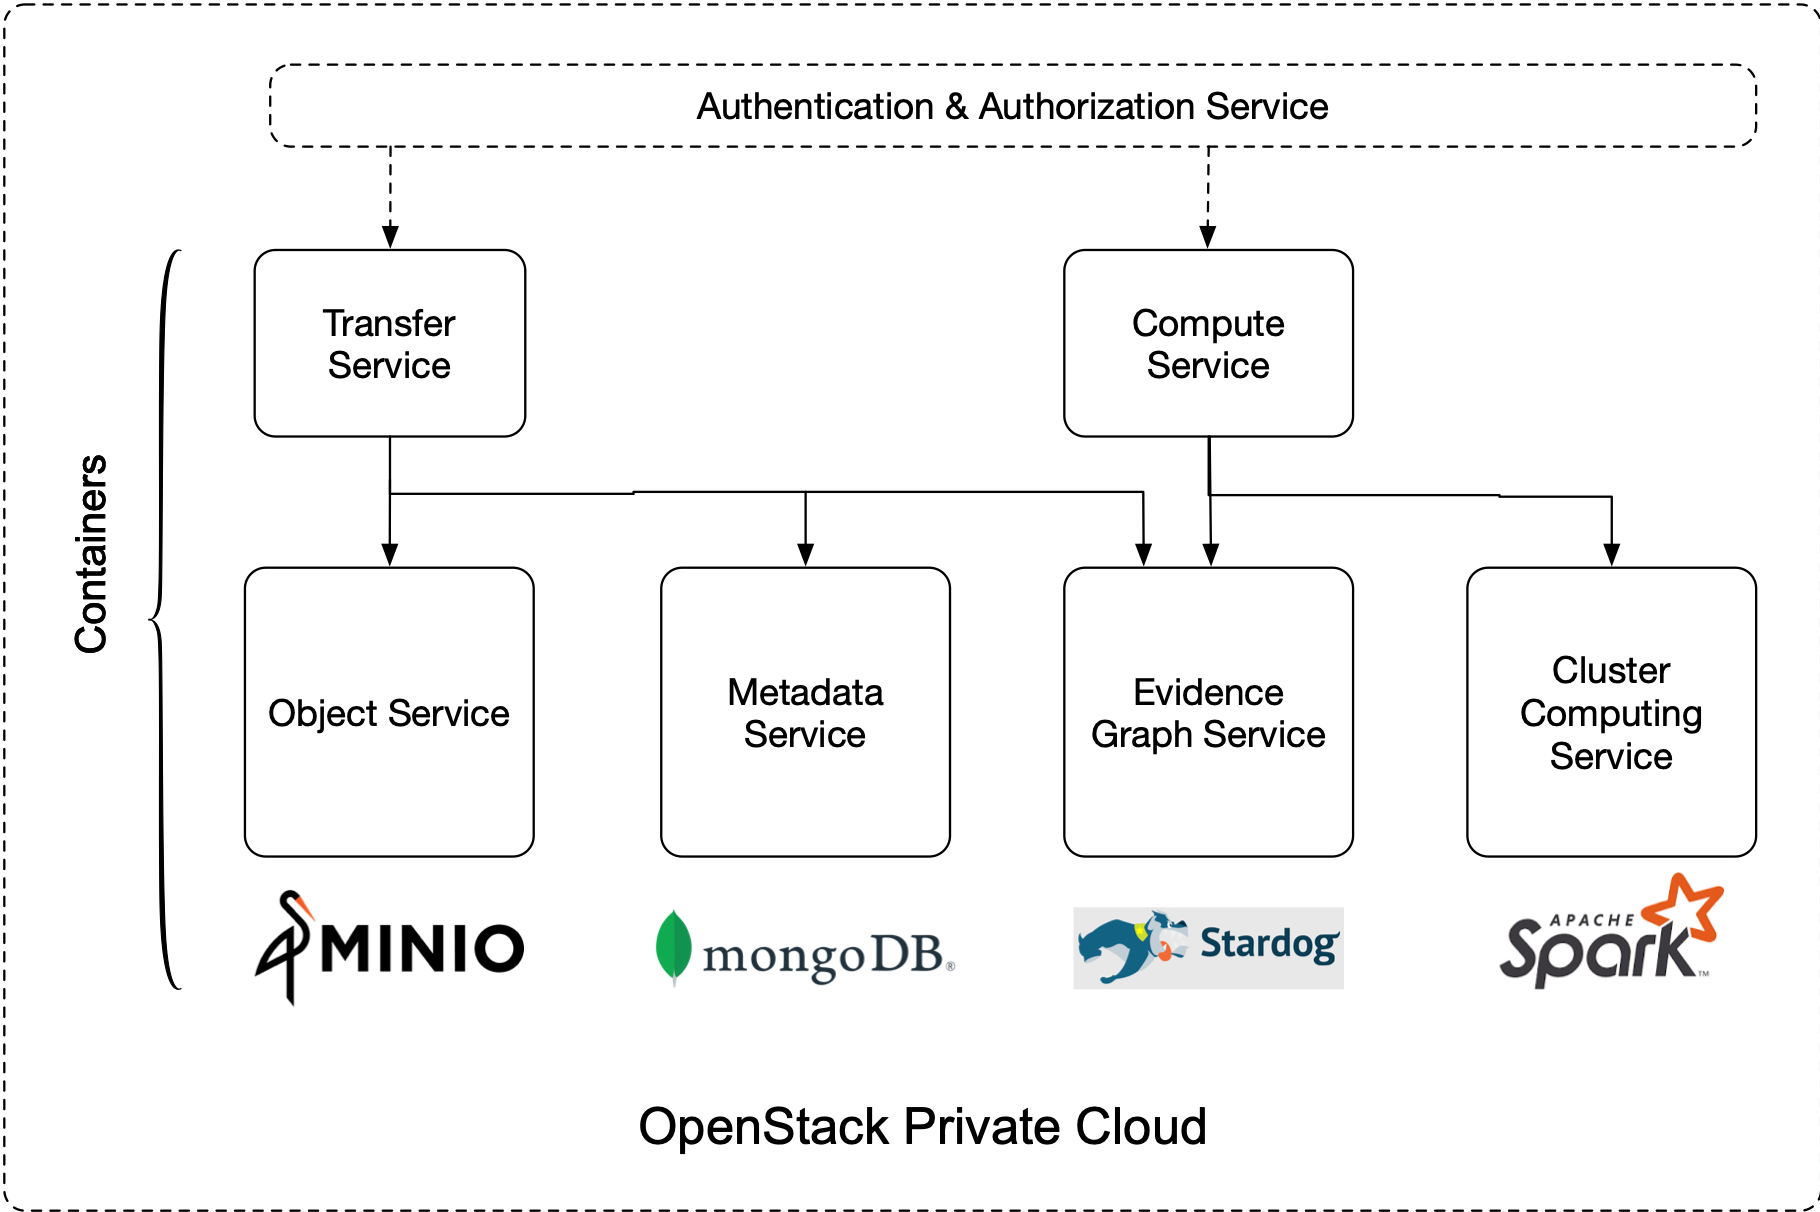

In [2]:
from IPython.display import Image
Image(filename="Architecture Image.png")

## Service Defintions

    Transfer Service: Used to upload data with associated metadata to framework
    Metadata Service (MDS): Handles minting identifiers...
    Compute Service: Runs nipype wf's spark jobs on uploaded data
    Evidence Graph Service: Queries Stardog to build Evidence Graph tracking object proveance

## This Demo demonstrates
    1.) Upload data to the framework
    2.) Retreive metadata of an uploaded object using MDS
    3.) Run a nipype workflow on uploaded data
    4.) View evidence graph of output from the workflow
    5.) Visualize evidence graph of an ouput from a workflow

## Use Transfer Service to Upload Data with Metadata
Transfer Service: Uploads (raw) data into MinIO and the metadata into MondoDB 

#### Metadata:

In [1]:
import requests 
import json

dataset_meta = {
    "@context":{
        "@vocab":"http://schema.org/"
    },
    "@type":"Dataset",
    "name":"sub-01_t1w_preproc.nii.gz",
    "description":"sub-01 preproccesed",
    "author":'Michael Notter',
    'folder':'inputs'
}

#### Service Call:
Invoking the Transfer Service to upload the data and the corresponding metadata:

In [ ]:
files = {
    'files':open('sub-01_t1w_preproc.nii.gz','rb'),
    'metadata':json.dumps(dataset_meta)
}

url = 'http://transfer-service/data/'
r = requests.post(url,files=files)
data_upload = r.json()
data_id1 = r.json()['Minted Identifiers'][0]



#### Transfer Service Response:
Examine the response to the service execution, includes newly minted PID

In [ ]:
data_upload

## Call MDS to Get Metadata for Minted ID
MDS: Retrieve Metadata for the Minted ID

In [ ]:
requests.get('http://mds.ors/' + data_id1).json()

## Upload Second Dataset Needed
Follow same steps as above to upload second dataset needed for our example workflow

In [ ]:
dataset_meta = {
    "@context":{
        "@vocab":"http://schema.org/"
    },
    "@type":"Dataset",
    "name":"sub-01_ses-test_task-fingerfootlips_bold.nii.gz",
    "description":"sub-01 task",
    "author":'Michael Notter',
    'folder':'inputs'
}

In [ ]:
files = {
    'files':open('sub-01_ses-test_task-fingerfootlips_bold.nii.gz','rb'),
    'metadata':json.dumps(dataset_meta)
}

url = 'http://transfer-service/data/'
r = requests.post(url,files=files)
data_id2 = r.json()['Minted Identifiers'][0]


## Upload Nipype WF via Transfer Service
Transfer Service can also be used to upload software

Software uploads also require associated metadata to be uploaded with the data

In [ ]:
software_meta = {
    "@context":{
        "@vocab":"http://schema.org/"
    },
    "@type":"SoftwareSourceCode",
    "name":"Sample Neuro Workflow",
    "description":"sub-01 task",
    "author":'Michael Notter',
    "folder":"inputs"
}

In [ ]:
files = {
    'files':open('new_script.py','rb'),
    'metadata':json.dumps(dataset_meta)
}

url = 'http://transfer-service/data/'
r = requests.post(url,files=files)
software_id = r.json()['Minted Identifiers'][0]


## Call Compute Service to Run WF on Posted Data

#### Compute Service Call 
Must pass compute service data ids of interest and which workflow to run

In [ ]:
job = {"datasetID":[data_id1,data_id2],"scriptID":software_id}

R = requests.post("http://sparksubmit/nipype",json = job)
job_id = R.content.decode()
job_id

job_id is an identifier representing the compuation being performed 

#### Using Minted Job ID Check Status of the Job with Second Call to Compute Service

In [ ]:
requests.get('http://sparksubmit/job/ark:99999/' + job_id).json()

## Review Job Outputs

#### Get all Minted Output IDs

In [ ]:
all_outputs = requests.get('http://mds.ors/ark:99999/' + job_id).json()['evi:supports']

#### Check Individual Output Metadata with Call to MDS

In [ ]:
output_of_interest = all_outputs[-3]
requests.get('http://mds.ors/' + output_of_interest).json()

## Call Evidence Graph Service to See Evidence Graph of Output

In [ ]:
eg = requests.get('http://eg/eg/' + output_of_interest).json()
eg

## Visualization of Evidence Graph

In [ ]:
visual = requests.get('http://visualize/' + output_of_interest).json()
#Will need to add things here to show html clearly
visual

### If of interest there's a second workflow that uses outputs of first

In [ ]:
dataset_meta = {
    "@context":{
        "@vocab":"http://schema.org/"
    },
    "@type":"Dataset",
    "name":"task-fingerfootlips_events.tsv",
    "description":"Events tsv for all subjects"
}

In [ ]:
files = {
    'files':open('task-fingerfootlips_events.tsv','rb'),
    'metadata':json.dumps(dataset_meta)
}

url = 'http://transfer-service/data/'
r = requests.post(url,files=files)
r.content.decode()
"ark:99999/88f69ce2-8725-4d5c-abd1-e418d32c55a2"

In [ ]:
dataset_meta = {
    "@context":{
        "@vocab":"http://schema.org/"
    },
    "@type":"SoftwareSourceCode",
    "name":"First Analysis Step",
    "description":"Follow-up script after preproccsing",
    "author":'Michael Notter'
}

In [1]:
{'@id': 'ark:99999/e98abd34-7745-4d82-8bed-81bf863734ce', 'eg:generatedBy': {'@id': 'ark:99999/3f81d2bd-82a3-490f-91ea-5203f3e5b525', 'eg:usedDataset': {'@id': 'ark:99999/4c334a12-1ae6-4ae9-b3e6-99398d16a44b', 'eg:generatedBy': {'@id': 'ark:99999/ef2a6cad-d531-4739-93cf-c616e512250d', 'eg:usedDataset': {'@id': 'ark:99999/c93b8e12-c10f-4f87-8a16-0bb775c88005', '@type': 'Dataset', 'author': 'Michael Notter', 'eg:generatedBy': {'@id': 'ark:99999/00b1935a-a3f9-47c3-bad0-410f9c9b9e4c', 'eg:usedDataset': {'@id': 'ark:99999/eff9c6a5-742a-4f68-af10-33860ed86f99', 'eg:generatedBy': {'@id': 'ark:99999/756364ca-e733-498b-bf02-5211c49f6d90', 'eg:usedDataset': {'@id': 'ark:99999/d0caff28-c328-46b6-a68a-dbb18565d3b8', 'eg:generatedBy': {'@id': 'ark:99999/d4a8cfe5-6270-4fe6-850a-1e0d4fb1b845'}, 'name': 'sub-01_ses-test_task-fingerfootlips_bold_roi_mcf.nii'}, 'eg:usedSoftware': 'ark:99999/c2b8b21a-cc5b-49f0-970b-424726cb2ad7'}, 'name': 'sub-01_t1w_preproc_brain_pve_2.nii.gz'}, 'eg:usedSoftware': 'ark:99999/e54e4ffa-3b52-4338-9b25-a5e6cfed8106'}, 'name': 'sub-01_t1w_preproc.nii.gz'}, 'eg:usedSoftware': 'ark:99999/347b9a85-fe84-4067-9916-19d4966a8ecd'}, 'name': 'sub-01_ses-test_task-fingerfootlips_bold_roi_mcf.nii.par'}, 'eg:usedSoftware': 'ark:99999/e88af7ba-b10a-4561-b99f-02e7ad991e7b'}, 'name': 'fwhm-4_ssub-01_ses-test_task-fingerfootlips_bold.nii'}

{'@id': 'ark:99999/e98abd34-7745-4d82-8bed-81bf863734ce',
 'eg:generatedBy': {'@id': 'ark:99999/3f81d2bd-82a3-490f-91ea-5203f3e5b525',
  'eg:usedDataset': {'@id': 'ark:99999/4c334a12-1ae6-4ae9-b3e6-99398d16a44b',
   'eg:generatedBy': {'@id': 'ark:99999/ef2a6cad-d531-4739-93cf-c616e512250d',
    'eg:usedDataset': {'@id': 'ark:99999/c93b8e12-c10f-4f87-8a16-0bb775c88005',
     '@type': 'Dataset',
     'author': 'Michael Notter',
     'eg:generatedBy': {'@id': 'ark:99999/00b1935a-a3f9-47c3-bad0-410f9c9b9e4c',
      'eg:usedDataset': {'@id': 'ark:99999/eff9c6a5-742a-4f68-af10-33860ed86f99',
       'eg:generatedBy': {'@id': 'ark:99999/756364ca-e733-498b-bf02-5211c49f6d90',
        'eg:usedDataset': {'@id': 'ark:99999/d0caff28-c328-46b6-a68a-dbb18565d3b8',
         'eg:generatedBy': {'@id': 'ark:99999/d4a8cfe5-6270-4fe6-850a-1e0d4fb1b845'},
         'name': 'sub-01_ses-test_task-fingerfootlips_bold_roi_mcf.nii'},
        'eg:usedSoftware': 'ark:99999/c2b8b21a-cc5b-49f0-970b-424726cb2ad7'},
  

In [ ]:
files = {
    'files':open('2nd Step.py','rb'),
    'metadata':json.dumps(dataset_meta)
}

url = 'http://transfer-service/data/'
r = requests.post(url,files=files)
r.content.decode()
ark:99999/251fb7cf-1711-472e-a54d-3834efba92ef

In [ ]:
data_ids = requests.get('http://mds.ors/ark:99999/fc813955-d8ba-4a88-800a-e5fc21a1119e').json()['eg:supports']
data_ids.append("ark:99999/88f69ce2-8725-4d5c-abd1-e418d32c55a2")
script_id = 'ark:99999/251fb7cf-1711-472e-a54d-3834efba92ef'
job = {"datasetID":data_ids,"scriptID":script_id}

R = requests.post("http://sparksubmit/nipype",json = job)
R.content.decode()